Ajit Joy

In [2]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_recall_fscore_support
from scipy import interp
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df = pd.read_csv("./seeds.csv")
df.head()

,area,perimeter,compactness,length of kernel,width of kernel,asymmetry coefficient,length of kernel groove,type
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1


In [4]:
df['type'].value_counts()

3    70
2    70
1    70
Name: type, dtype: int64

In [5]:
df.isna().sum()

area                       0
perimeter                  0
compactness                0
length of kernel           0
width of kernel            0
asymmetry coefficient      0
length of kernel groove    0
type                       0
dtype: int64

There are no missing values. Let's check the boxplots of the numerical columns for outliers. We will do this in three slices

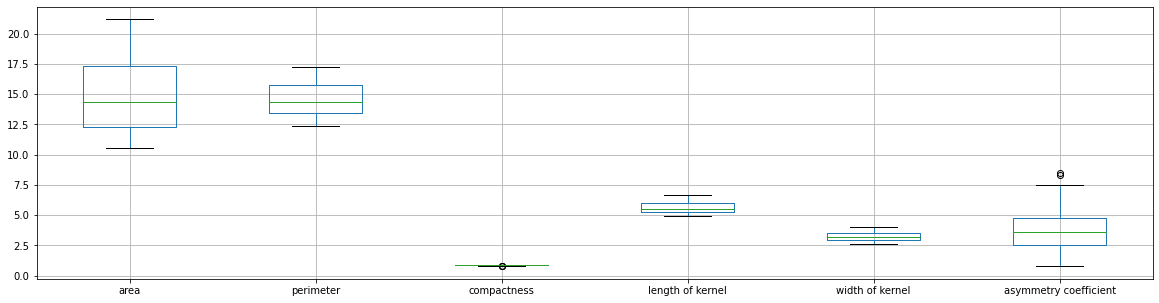

In [6]:
df.loc[:,'area':'asymmetry coefficient'].boxplot(figsize=(20,5))
plt.show()

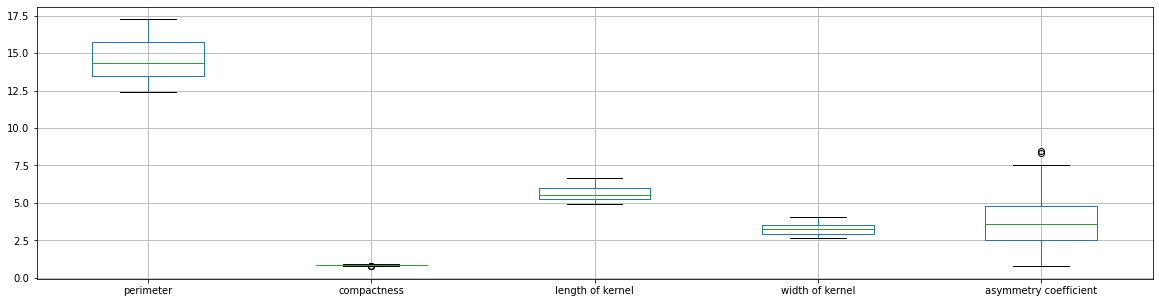

In [7]:
df.loc[:,'perimeter':'asymmetry coefficient'].boxplot(figsize=(20,5))
plt.show()

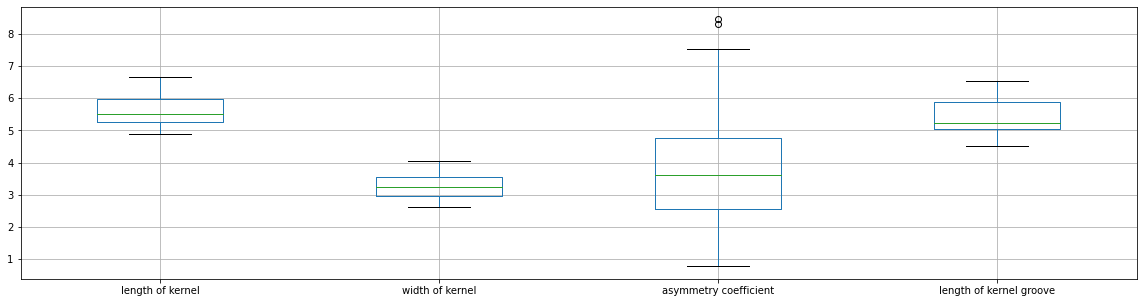

In [8]:
df.loc[:,'length of kernel':'length of kernel groove'].boxplot(figsize=(20,5))
plt.show()

The most outliers tend to be related to field, perimeter, and asymmetry coefficient, with asymmetry coefficient being the most prevalent, according to the boxplots created above. StandardScaler can be applied on all predictor columns except the asymmetry coefficient.

Data Preparation

In [9]:
mapper = {1: 1, 2: 0, 3: 0}
df['type'] = df['type'].replace(mapper)
df['type'].value_counts()

0    140
1     70
Name: type, dtype: int64

In [10]:
names_all = [c for c in df if c not in ['type']]

names_outliers = ['asymmetry coefficient']
names_no_outliers = list(set(names_all) - set(names_outliers))

In [11]:
class AddColumnNames(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return pd.DataFrame(data=X, columns=self.columns)

In [12]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X[self.columns]

In [13]:
preprocess_pipeline = make_pipeline(
    AddColumnNames(columns=names_all),
    FeatureUnion(transformer_list=[
        ("outlier_columns", make_pipeline(
            ColumnSelector(columns=names_outliers),
            FunctionTransformer(np.log, validate=True),
            RobustScaler()
        )),
        ("no_outlier_columns", make_pipeline(
            ColumnSelector(columns=names_no_outliers),
            StandardScaler()
        ))
    ])
)

Separate the coloumns into targets and predictors

In [14]:
y = df['type']
X = df.drop('type', axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

Grid Search for Best Parameters of Classifiers

In [15]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('svm', svm.SVC(probability=True))])

param_grid = {
    'svm__C': [0.1, 1, 10, 100],  
    'svm__gamma': [1, 0.1, 0.01, 0.001], 
    'svm__kernel': ['rbf', 'linear', 'poly']}

search = GridSearchCV(pipe, param_grid, cv=10, iid=False, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

SVM_best_params = search.best_params_
SVM_best_model = search.best_estimator_

Best CV score = 0.971:
Best parameters:  {'svm__C': 100, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}


C:\Users\ajit.joy\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


In [16]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('rf', RandomForestClassifier())])

param_grid = {
    'rf__n_estimators' : [10,20,30],
    'rf__max_depth': [2, 4, 6, 8]
}

search = GridSearchCV(pipe, param_grid, cv=10, iid=False, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.923:
Best parameters:  {'rf__max_depth': 2, 'rf__n_estimators': 10}


C:\Users\ajit.joy\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


Compare Classifiers on Test Set

In [17]:
mean_fpr = np.linspace(start=0, stop=1, num=100)

In [18]:
def evaluate_model(X_test, y_test, model):
    _probabilities = model.predict_proba(X_test)[:, 1]
    
    _predicted_values = model.predict(X_test)
        
    _accuracy = accuracy_score(y_test, _predicted_values)
        
    _precision, _recall, _f1_score, _ = precision_recall_fscore_support(y_test, _predicted_values, labels=[1])
    
    _fpr, _tpr, _ = roc_curve(y_test, _probabilities)
        
    _tpr_transformed = np.array([interp(mean_fpr, _fpr, _tpr)])
    
    _auc = auc(_fpr, _tpr)
            
    return _accuracy, _precision[0], _recall[0], _f1_score[0], _tpr_transformed, _auc

In [19]:
SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score, SVM_tpr, SVM_auc = evaluate_model(X_test, y_test, SVM_best_model)
RF_accuracy, RF_precision, RF_recall, RF_f1_score, RF_tpr, RF_auc = evaluate_model(X_test, y_test, RF_best_model)

<ipython-input-18-813812429e8d>:12: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  _tpr_transformed = np.array([interp(mean_fpr, _fpr, _tpr)])
<ipython-input-18-813812429e8d>:12: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  _tpr_transformed = np.array([interp(mean_fpr, _fpr, _tpr)])


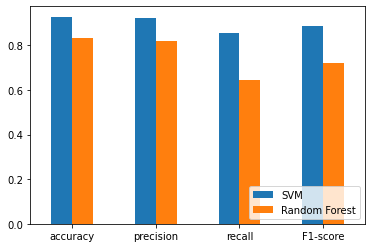

In [20]:
SVM_metrics = np.array([SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score])
RF_metrics = np.array([RF_accuracy, RF_precision, RF_recall, RF_f1_score])
index = ['accuracy', 'precision', 'recall', 'F1-score']
df_metrics = pd.DataFrame({'SVM': SVM_metrics, 'Random Forest': RF_metrics}, index=index)
df_metrics.plot.bar(rot=0)
plt.legend(loc="lower right")
plt.show()

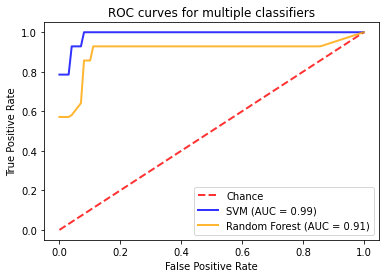

In [21]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
plt.plot(mean_fpr, SVM_tpr[0,:], lw=2, color='blue', label='SVM (AUC = %0.2f)' % (SVM_auc), alpha=0.8)
plt.plot(mean_fpr, RF_tpr[0,:], lw=2, color='orange', label='Random Forest (AUC = %0.2f)' % (RF_auc), alpha=0.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for multiple classifiers')
plt.legend(loc="lower right")
plt.show()

Train a Final Model

In [22]:
def transform(dict):
    return {key.replace('svm__','') :  value for key, value in dict.items()}

pipe = make_pipeline(preprocess_pipeline, svm.SVC(**transform(SVM_best_params)))

final_model = pipe.fit(X, y)

In [23]:
filename = 'final_model.sav'
pickle.dump(final_model, open(filename, 'wb'))

Training an MLP Classifier Model

In [24]:
df.keys()

Index(['area', 'perimeter', 'compactness', 'length of kernel',
       'width of kernel', 'asymmetry coefficient', 'length of kernel groove',
       'type'],
      dtype='object')

In [25]:
df['type'].shape

(210,)

In [26]:
X = df[df.columns[0:6]]
y = df['type']

In [27]:
X.keys()

Index(['area', 'perimeter', 'compactness', 'length of kernel',
       'width of kernel', 'asymmetry coefficient'],
      dtype='object')

In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [29]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(30,30,30))
mlp.fit(X_train,y_train)

C:\Users\ajit.joy\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(30, 30, 30))

In [30]:
MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(30, 30, 30), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

MLPClassifier(hidden_layer_sizes=(30, 30, 30))

In [31]:
predictions = mlp.predict(X_test)
from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(y_test,predictions))

[[33  2]
 [ 3 15]]


In [32]:
class_rep = classification_report(y_test,predictions)

print(class_rep)

              precision    recall  f1-score   support

           0       0.92      0.94      0.93        35
           1       0.88      0.83      0.86        18

    accuracy                           0.91        53
   macro avg       0.90      0.89      0.89        53
weighted avg       0.91      0.91      0.90        53



In [33]:
filename = 'mlp_classifier_model.sav'
pickle.dump(class_rep, open(filename, 'wb'))

Training a Naive Bayes Model

In [34]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()

gnb.fit(X_train, y_train)

y_pred = gnb.predict(X_test)

from sklearn import metrics

naive_based_model = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:", naive_based_model)

Accuracy: 0.8867924528301887


In [35]:
filename = 'naive_bayes_model.sav'
pickle.dump(naive_based_model, open(filename, 'wb'))